In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
%matplotlib inline
sns.set_palette("pastel")

import warnings
warnings.filterwarnings('ignore')

import folium
from folium.plugins import MarkerCluster
import json
import re

## 분석(1) 입회한 회원 정보

총 8,965건 중 8,457건의 입회한 회원 정보 이용 <br>
2006.11~2021.07의 입회한 회원에 대한 정보를 파악

In [2]:
# 입회+회원정보
df = pd.read_csv('데이터/입회회원.csv') 
df.head()

,입회ID,고객번호,회원권번호,CMS코드,입회일,실금액,회원권상태,계약직원,담당직원,고객명,생년월일,성별,연락처,주소,고객구분,고객등급,고객분류,회원권보유개수
0,8423,20194056,VV-01,4007.0,2019-08-30,"36,000,000.00",보유,이성원,이성원,강상만,1966-04-03,남,010-2756-9993,NaN,한K,ACE,개인,1
1,6404,20196999,KCTN-01,3221.0,2019-12-05,0.00,보유,김석희,김석희,강상태,1961-05-07,남,010-6105-5530,NaN,한K,ACE,개인,1
2,4615,20204522,JP-01,4753.0,2020-12-28,"16,500,000.00",보유,김명식,김명식,강석균,1977-01-17,남,010-3870-0040,NaN,한K,ACE,개인,1
3,5766,2001261,KCSN-01,2710.0,2018-10-26,"9,900,000.00",양도,정준호,유회경,강석자,1957-08-15,여,010-2798-3699,제주특별자치도 서귀포시 표선면 표선백사로58번길 94-16,일반,ACE,개인,0
4,4188,2021875,JP-01,5253.0,2021-05-25,"16,500,000.00",보유,한나라,한나라,강석호,1956-05-02,남,010-9084-8146,NaN,한K,ACE,개인,1


In [3]:
# 입회일 및 연령대 계산 
df['입회일'] = pd.to_datetime(df['입회일'], format="%Y-%m-%d")
df['생년월일'] = pd.to_datetime(df['생년월일'], format="%Y-%m-%d")

df = df[pd.notnull(df['입회일'])]
df = df[pd.notnull(df['생년월일'])]

df['A_YEAR'] = pd.DatetimeIndex(df['입회일']).year
df['A_MONTH'] = pd.DatetimeIndex(df['입회일']).month
df['A_DAY'] = pd.DatetimeIndex(df['입회일']).day
# df['A_YEAR'] = df['A_YEAR'].astype(int)

df['B_YEAR'] = pd.DatetimeIndex(df['생년월일']).year
df['B_MONTH'] = pd.DatetimeIndex(df['생년월일']).month
df['B_DAY'] = pd.DatetimeIndex(df['생년월일']).day

# 입회요일 계산

week_day = {
    0 : '월요일',
    1 : '화요일',
    2 : '수요일',
    3 : '목요일',
    4 : '금요일',
    5 : '토요일',
    6 : '일요일'
}

df['A_WEEK_DAY'] = [week_day[k] for k in df['입회일'].dt.dayofweek]

df['AGE'] = 2021 - df['B_YEAR']

df['AGE_GRP'] = 0

df.loc[df['AGE'] < 20, 'AGE_GRP'] = '10대 이하'
df.loc[(df['AGE'] >= 20) & (df['AGE'] < 30), 'AGE_GRP'] = '20대'
df.loc[(df['AGE'] >= 30) & (df['AGE'] < 40), 'AGE_GRP'] = '30대'
df.loc[(df['AGE'] >= 40) & (df['AGE'] < 50), 'AGE_GRP'] = '40대'
df.loc[(df['AGE'] >= 50) & (df['AGE'] < 60), 'AGE_GRP'] = '50대'
df.loc[(df['AGE'] >= 60) & (df['AGE'] < 70), 'AGE_GRP'] = '60대'
df.loc[(df['AGE'] >= 70) & (df['AGE'] < 80), 'AGE_GRP'] = '70대'
df.loc[df['AGE'] >= 80, 'AGE_GRP'] = '80세 이상'

### 01.입회 건수 성별 비율

In [4]:
df['성별'].value_counts()

남    6222
여    2179
Name: 성별, dtype: int64

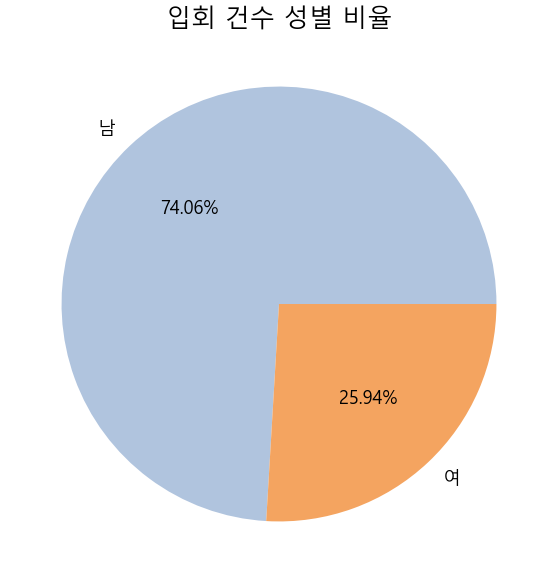

In [5]:
plt.figure(figsize=(12, 10))
df['성별'].value_counts().plot.pie(autopct="%.2f%%",
                                   colors=['lightsteelblue', 'sandybrown'], fontsize=18)
plt.title('입회 건수 성별 비율', fontsize=25)
#plt.text('성별 정보가 없는 56건 제외',fontsize=13)
plt.xticks(fontsize=18)
plt.ylabel('')
plt.show()

### 02.연령대별 입회 건수

In [7]:
df['AGE_GRP'].value_counts()

60대       3247
50대       2534
70대       1185
40대        671
20대        299
30대        248
80세 이상     198
10대 이하      75
Name: AGE_GRP, dtype: int64

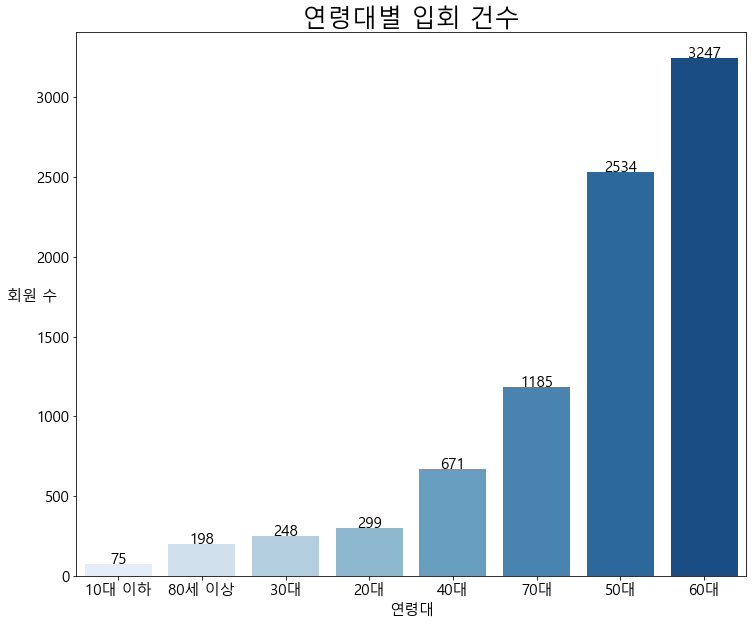

In [8]:
age = df['AGE_GRP'].value_counts(ascending=True)

plt.figure(figsize=(12, 10))
ax = sns.barplot(x=age.index,
                 y=age,
                 palette='Blues')

for p in ax.patches:
    ax.annotate("%d"%(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', fontsize=15)
    
plt.title('연령대별 입회 건수', fontsize=25)
plt.yticks(fontsize=15)
plt.xticks(fontsize =15)
plt.ylabel('회원 수', fontsize=15, rotation=360)
plt.xlabel('연령대', fontsize=15)
plt.show()

### 03.지역별 입회 건수

In [3]:
erp_df = pd.read_csv('데이터/ERP엑셀DB_0721_1.csv')
erp_df.dropna(subset=['DM주소'], inplace=True)
erp_df = erp_df.drop_duplicates(['DM주소'], keep='first')

name_split = erp_df['DM주소'].str.split(" ")

erp_df['광역시도'] = name_split.str.get(0)
erp_df['시군구'] = name_split.str.get(1)

erp_df.dropna(subset=['DM주소', '광역시도', '시군구'], how='all', inplace=True)

geo_path = '데이터/TL_SCCO_SIG.json' # 지도 정보
geo_str = json.load(open(geo_path, encoding='utf-8'))

df_all = erp_df['시군구'].value_counts()
df_all = df_all.reset_index(name='count')

all_map = folium.Map(location=[36.139867,128.1114614], tiles='cartodbpositron', zoom_start=6)
all_map.choropleth(geo_data=geo_str, 
                   data=df_all,
                   columns=['index', 'count'],
                   fill_color='YlOrRd', fill_operacity=0.7, line_opacity=0.3,
                   key_on='properties.SIG_KOR_NM')
all_map

### 04.연도별 및 월별 입회 회원수

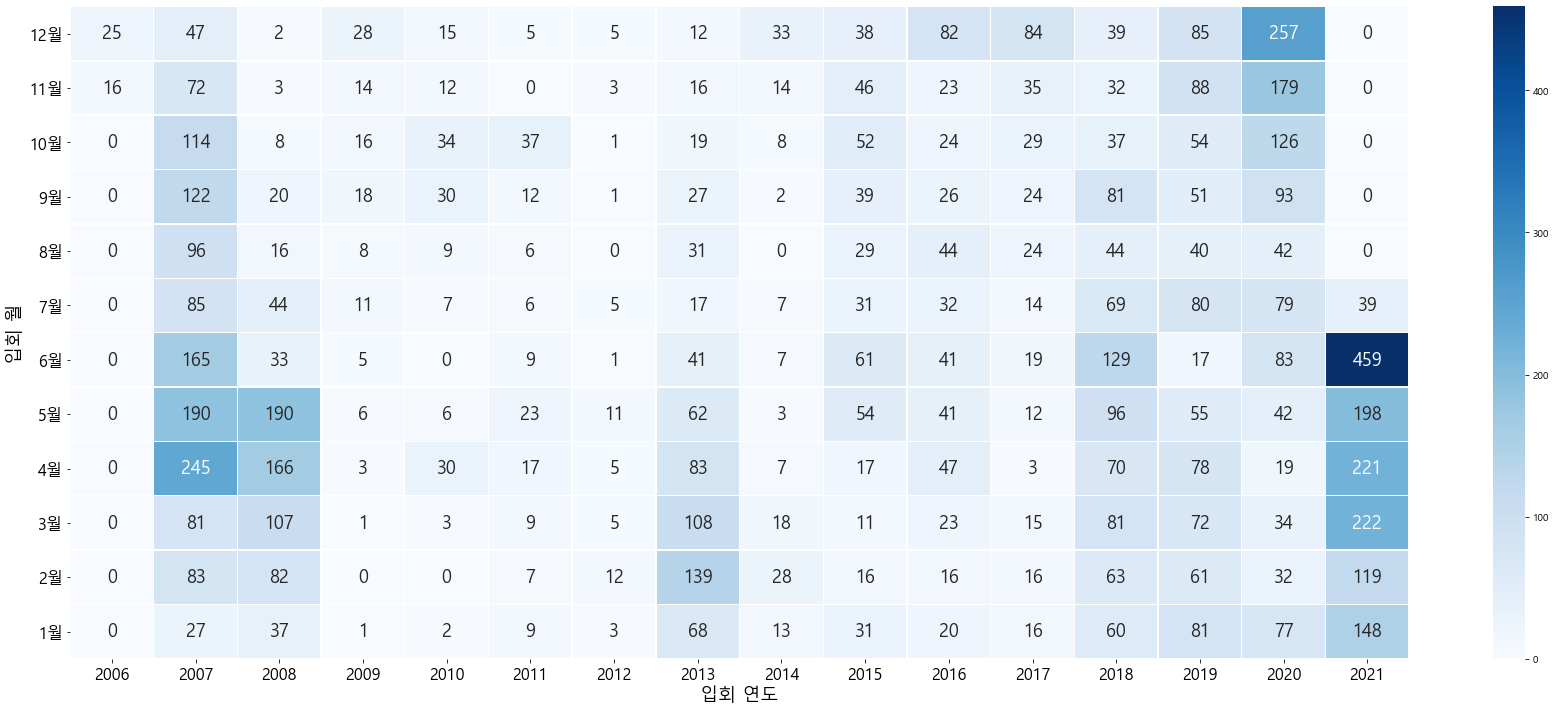

In [9]:
pivot = df.groupby(['A_MONTH', 'A_YEAR']).size().unstack()
rst = pivot.fillna(0)
rst = rst.sort_index(ascending=False)
rst = rst.astype(int)
rst = rst.rename(index={1:'1월', 2:'2월', 3:'3월', 4:'4월', 5:'5월', 6:'6월',
                        7:'7월', 8:'8월', 9:'9월', 10:'10월', 11:'11월', 12:'12월'})
plt.figure(figsize=(30, 12))
ax = sns.heatmap(rst, annot=True, fmt='d', cmap='Blues',
                 linewidths=.5, annot_kws={'size' : 18})
plt.xticks(np.arange(0.5, len(rst.columns), 1), rst.columns, fontsize=16)
plt.yticks(np.arange(0.5, len(rst.index), 1), rst.index, fontsize=16, rotation=360)
plt.xlabel('입회 연도', fontsize=18)
plt.ylabel('입회 월', fontsize=18)
plt.show()

### 05.2020~2021년 많이 판매된 회원권

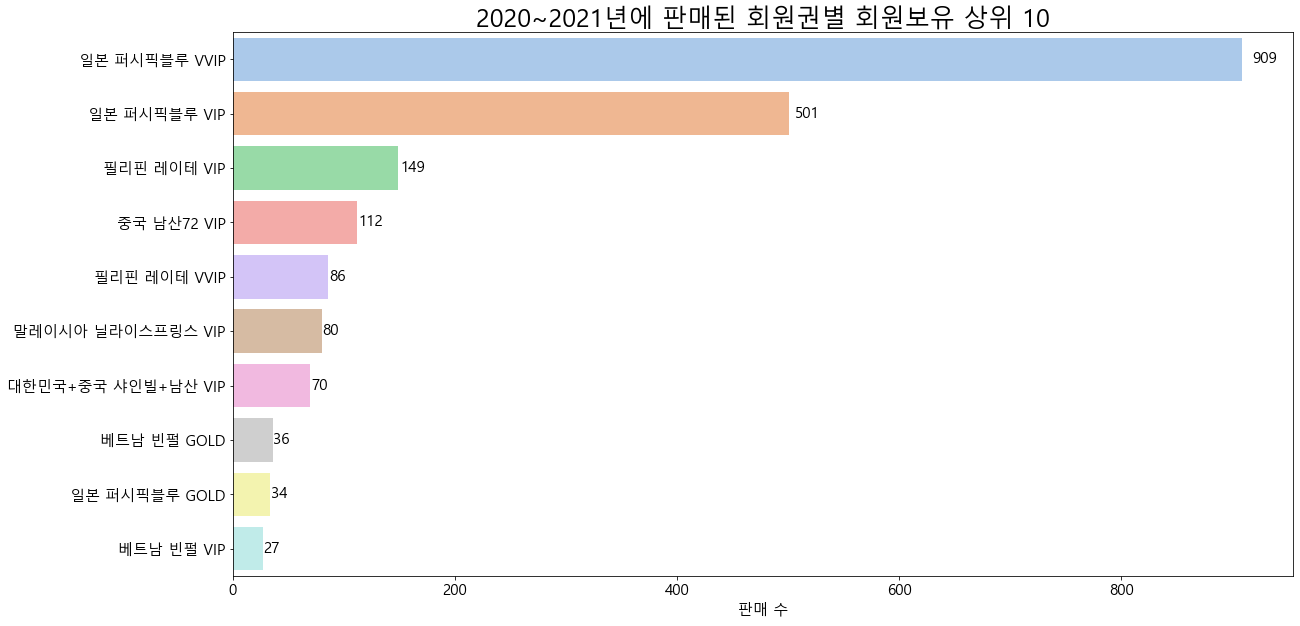

In [16]:
year = [2020, 2021]
y_2021 = df.loc[df['A_YEAR'].isin(year)]
y_2021 = y_2021['회원권번호'].value_counts().head(10)

plt.figure(figsize=(19, 10))
ax = sns.barplot(y=y_2021.index,
                 x=y_2021,
                 palette='pastel')
for p in ax.patches:
    x, y, width, height = p.get_bbox().bounds
    ax.text(width*1.01, y+height/2, "%d"%(width), va='center', fontsize=15)
y_label= ['일본 퍼시픽블루 VVIP', '일본 퍼시픽블루 VIP', '필리핀 레이테 VIP',
          '중국 남산72 VIP', '필리핀 레이테 VVIP', '말레이시아 닐라이스프링스 VIP',
          '대한민국+중국 샤인빌+남산 VIP', '베트남 빈펄 GOLD', '일본 퍼시픽블루 GOLD',
          '베트남 빈펄 VIP']
ax.set_yticklabels(y_label)  
plt.title('2020~2021년에 판매된 회원권별 회원보유 상위 10', fontsize=25)
plt.yticks(fontsize=15)
plt.ylabel('')
plt.xticks(fontsize=15)
plt.xlabel('판매 수', fontsize=15)
plt.show()

### 06.2020년 12월,2021년 6월에 많이 판매된 회원권 

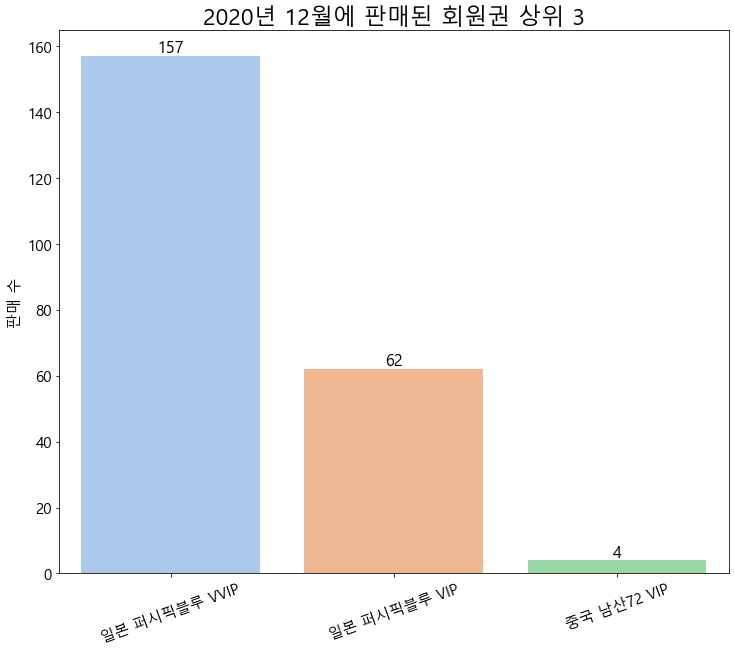

In [18]:
df_2020_12 = df[(df['A_YEAR']==2020)&(df['A_MONTH']==12)]
df_2020_12 = df_2020_12['회원권번호'].value_counts().head(3)

plt.figure(figsize=(12, 10))
ax = sns.barplot(y=df_2020_12,
                 x=df_2020_12.index,
                 palette='pastel')
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16, color='black', xytext=(0, 8),
                 textcoords='offset points')
    
x_label= ['일본 퍼시픽블루 VVIP','일본 퍼시픽블루 VIP','중국 남산72 VIP']
ax.set_xticklabels(x_label)  
plt.title('2020년 12월에 판매된 회원권 상위 3', fontsize=23)
plt.yticks(fontsize=15)
plt.ylabel('판매 수',fontsize=15)
plt.xticks(fontsize=15, rotation=20)
plt.xlabel(' ')
plt.show()

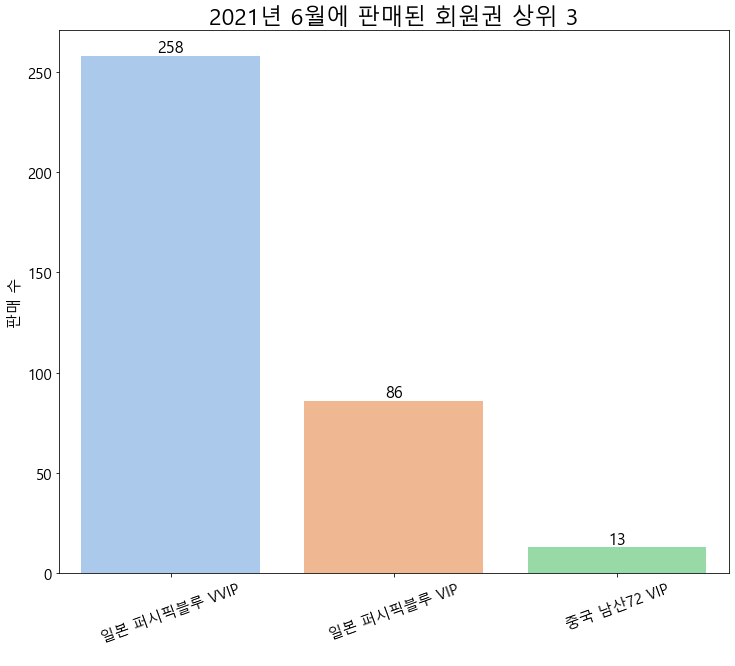

In [17]:
df_2021_06 = df[(df['A_YEAR']==2021)&(df['A_MONTH']==6)]
df_2021_06 = df_2021_06['회원권번호'].value_counts().head(3)

plt.figure(figsize=(12, 10))
ax = sns.barplot(y=df_2021_06,
                 x=df_2021_06.index,
                 palette='pastel')
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16, color='black', xytext=(0, 8),
                 textcoords='offset points')
    
x_label= ['일본 퍼시픽블루 VVIP','일본 퍼시픽블루 VIP','중국 남산72 VIP']
ax.set_xticklabels(x_label)  
plt.title('2021년 6월에 판매된 회원권 상위 3', fontsize=23)
plt.yticks(fontsize=15)
plt.ylabel('판매 수',fontsize=15)
plt.xticks(fontsize=15, rotation=20)
plt.xlabel(' ')
plt.show()

### 07. 연도별 및 연령대별 입회 회원수

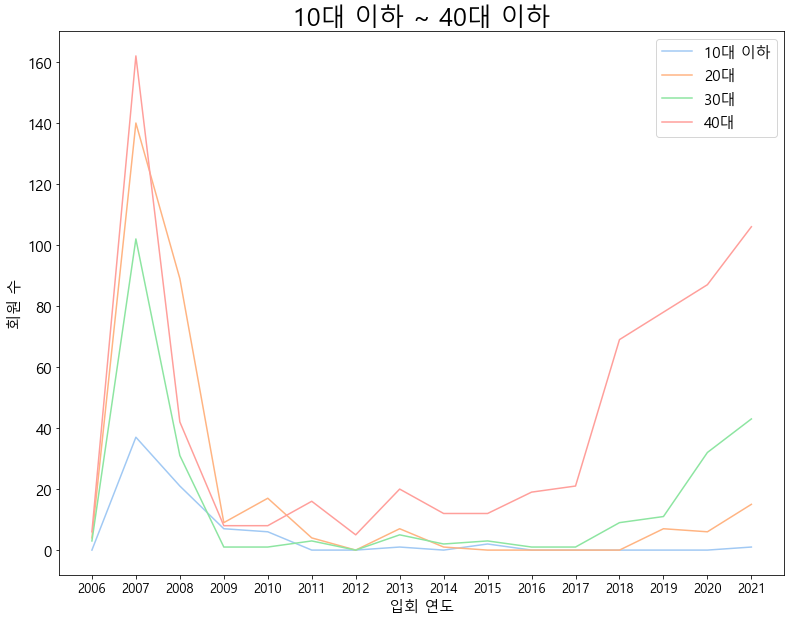

In [10]:
age1 = ['10대 이하', '20대', '30대', '40대']

df1 = df.loc[df['AGE_GRP'].isin(age1)]
df_1 = df1.groupby(['A_YEAR', 'AGE_GRP']).size().unstack()
df_1 = df_1.fillna(0)
df_1 = df_1.astype(int)
df_1_40 = df_1[['40대']]
df_1_30 = df_1[['30대']]
df_1_20 = df_1[['20대']]
df_1_10 = df_1[['10대 이하']]

plt.figure(figsize=(13, 10))
ax1=plt.plot(df_1_10, label='10대 이하')
ax2=plt.plot(df_1_20, label='20대')
ax3=plt.plot(df_1_30, label='30대')
ax4=plt.plot(df_1_40, label='40대')

plt.legend(loc='upper right', fontsize=15)
plt.title('10대 이하 ~ 40대 이하', fontsize=25)
plt.xticks(np.arange(2006, 2022, 1), fontsize=13)
plt.yticks(fontsize=15)
plt.ylabel('회원 수', fontsize=15)
plt.xlabel('입회 연도', fontsize=15)
plt.show()

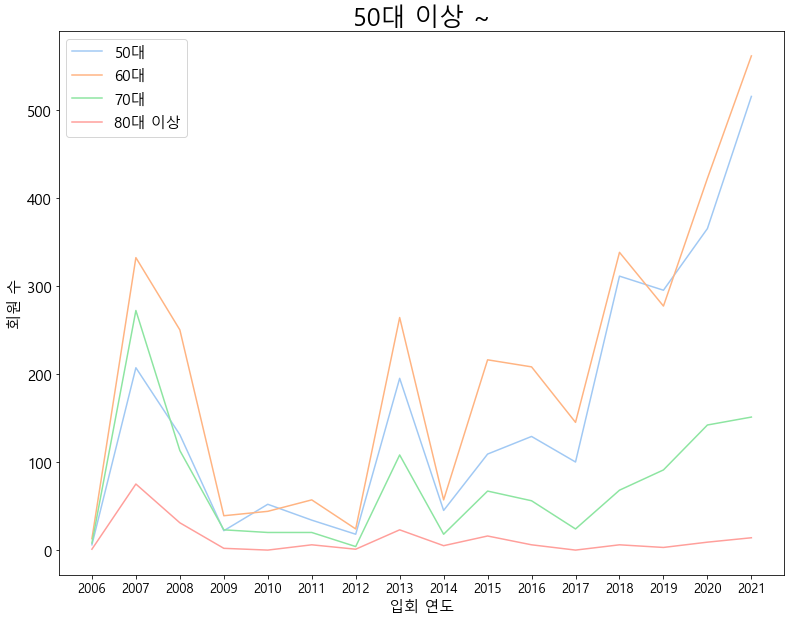

In [11]:
age2 = ['50대', '60대', '70대', '80세 이상']

df2 = df.loc[df['AGE_GRP'].isin(age2)]

df_2 = df2.groupby(['A_YEAR', 'AGE_GRP']).size().unstack()
df_2 = df_2.fillna(0)
df_2 = df_2.astype(int)
df_2_50 = df_2[['50대']]
df_2_60 = df_2[['60대']]
df_2_70 = df_2[['70대']]
df_2_80 = df_2[['80세 이상']]

plt.figure(figsize=(13, 10))
plt.plot(df_2_50, label='50대')
plt.plot(df_2_60, label='60대')
plt.plot(df_2_70, label='70대')
plt.plot(df_2_80, label='80대 이상')
plt.title('50대 이상 ~', fontsize=25)
plt.xticks(np.arange(2006, 2022, 1), fontsize=13)
plt.yticks(fontsize=15)
plt.xlabel('입회 연도', fontsize=15)
plt.ylabel('회원 수', fontsize=15)
plt.legend(loc='upper left', fontsize=15)
plt.show()

### 08.고객등급별 회원권 보유 개수

In [12]:
df.drop_duplicates(['고객번호'],inplace=True) # 중복 고객 제거 

df['count'] = 0

df.loc[df['회원권보유개수'] <= 1, 'count'] = '1개 이하'
df.loc[df['회원권보유개수'] == 2, 'count'] = '2개'
df.loc[df['회원권보유개수'] == 3, 'count'] = '3개'
df.loc[df['회원권보유개수'] == 4, 'count'] = '4개'
df.loc[df['회원권보유개수'] >= 5, 'count'] = '5개 이상'

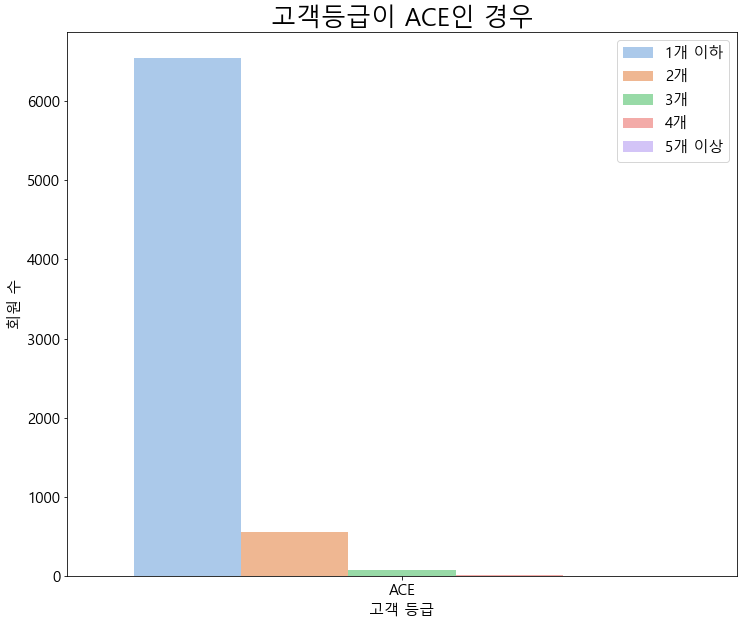

In [13]:
plt.figure(figsize=(12, 10))
ace = df.loc[df['고객등급'] == 'ACE']

sns.countplot(ace['고객등급'],
              hue=ace['count'],
              palette='pastel')
plt.title('고객등급이 ACE인 경우', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('고객 등급', fontsize=15)
plt.ylabel('회원 수', fontsize=15)
plt.show()

In [15]:
n_ace.groupby(['고객등급','count']).size()

고객등급  count
MVG   1개 이하     9
      2개        7
      3개        5
      4개        2
      5개 이상     4
SVIP  1개 이하    23
      2개       15
      3개        5
      4개        3
VIP   1개 이하    25
      2개       24
      3개        8
      4개        6
      5개 이상     2
dtype: int64

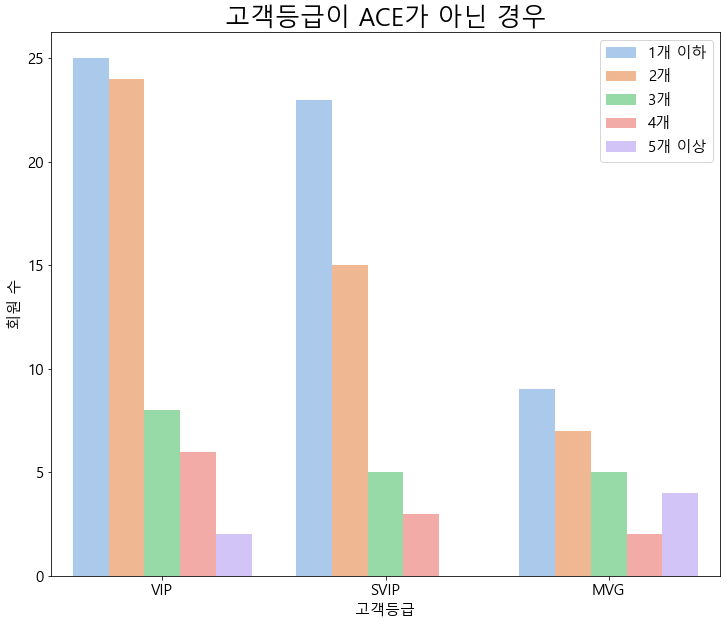

In [14]:
n_ace = df.loc[df['고객등급'] != 'ACE']

plt.figure(figsize=(12, 10))
sns.countplot(n_ace['고객등급'],
              hue=n_ace['count'].sort_values(),
              palette='pastel',
             order=["VIP","SVIP","MVG"])

plt.title('고객등급이 ACE가 아닌 경우', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('고객등급', fontsize=15)
plt.ylabel('회원 수', fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.show()

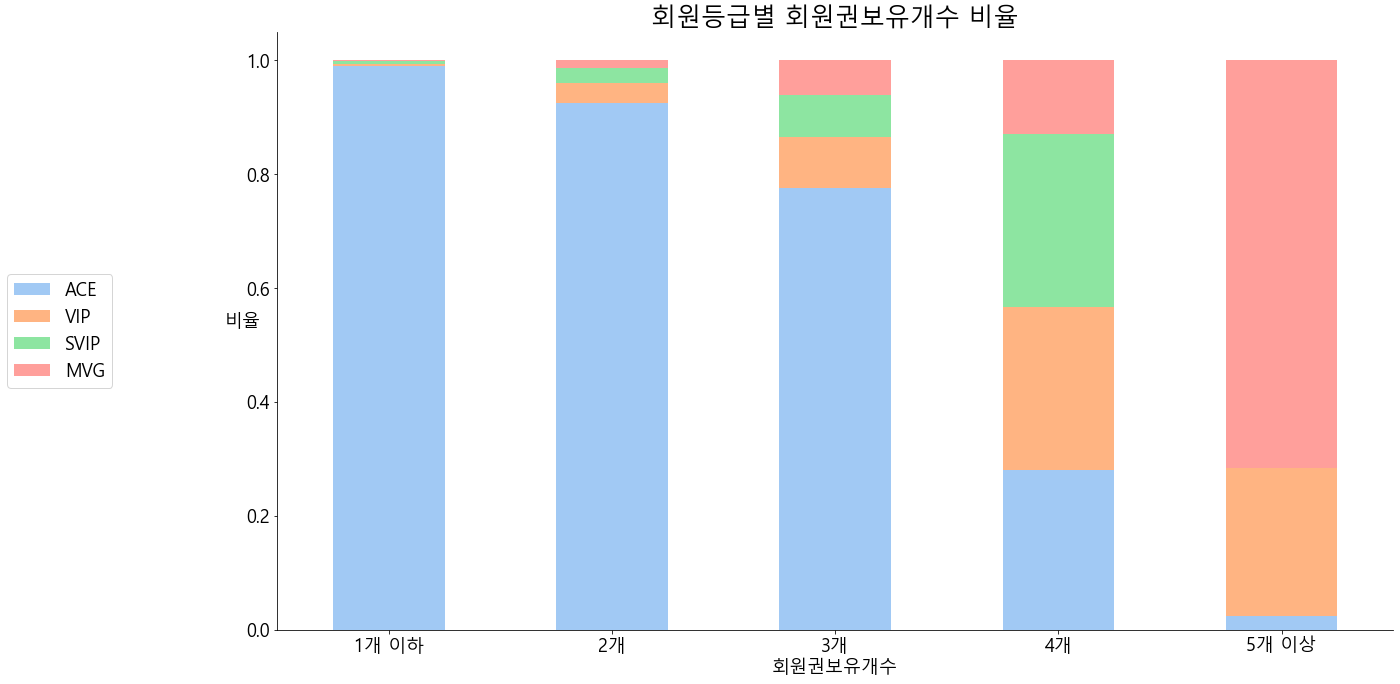

In [19]:
mn_cnt_class = df.groupby(['count', '고객등급']).sum()['입회ID']
mn_cnt_class_sum = df.groupby(['count']).sum()['입회ID']

mn_cnt_class_ratio = mn_cnt_class / mn_cnt_class_sum
mn_cnt_class_ratio = round(mn_cnt_class_ratio.unstack().fillna(0), 4)
mn_cnt_class_ratio_df = pd.DataFrame(mn_cnt_class_ratio)
mn_cnt_class_ratio_df = mn_cnt_class_ratio_df[['ACE','VIP','SVIP','MVG']]

mn_cnt_class_ratio_df.plot.bar(stacked=True, figsize=(20, 11))
plt.xticks(fontsize=18, rotation=360)
plt.legend(loc='center left',bbox_to_anchor=(-0.25,0.5), fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('비율', fontsize=18, rotation=360)
plt.xlabel('회원권보유개수', fontsize=18)
plt.title('회원등급별 회원권보유개수 비율', fontsize=25)
sns.despine()
plt.show()

### 09.회원권 출시 직후 100일과 그 이후 100일의 판매건수

In [23]:
df = pd.read_csv('데이터/입회+회원권.csv') 
date = pd.read_csv('데이터/회원권출시날짜.csv') # 회원권별 첫 입회일

In [24]:
date.rename(columns={'입회일' : '출시일'}, inplace=True)

df1 = pd.merge(df, date, on='골프장이름')
df = df1

df1.rename(columns={'회원권_회원권번호' : '회원권번호', '국가_x' : '국가'}, inplace=True)
del_col = ['고객번호', '입회_회원권번호', 'CMS코드', '국가_y']
df1.drop(del_col, axis=1, inplace=True)

df['입회ID'] = df['입회ID'].astype(str)

# 연도, 월 추가
df['입회일'] = pd.to_datetime(df['입회일'], format="%Y-%m-%d")
df = df[pd.notnull(df['입회일'])]

df['입회연도'] = df['입회일'].dt.year
df['입회연도'] = df['입회연도'].astype(int)

df['입회월'] = df['입회일'].dt.month
df['입회월'] = df['입회월'].astype(int)

df['출시일'] = pd.to_datetime(df['출시일'], format="%Y-%m-%d")
df = df[pd.notnull(df['출시일'])]

df['출시연도'] = df['출시일'].dt.year
df['출시연도'] = df['출시연도'].astype(int)

df['출시월'] = df['출시일'].dt.month
df['출시월'] = df['출시월'].astype(int)

df['기간'] = df['입회일'] - df['출시일']
df['days'] = 0
df.loc[(df['기간'] <= '100days'), 'days'] = '100일 이내'
df.loc[(df['기간'] > '100days') & (df['기간'] <= '200days'), 'days'] = '100일 이후'

amount = df.groupby(['회원권번호', 'days']).count()['입회ID'].reset_index(name='count')

con = (amount['days'] == '100일 이내') | (amount['days'] == '100일 이후')

amount = amount.loc[con]

am = amount['회원권번호'].value_counts()
am = am.reset_index(name='count')
am = am.loc[am['count'] != 1]
lst = list(am['index'])

amount = amount.loc[amount['회원권번호'].isin(lst)]
amount

,회원권번호,days,count
1,CB-01,100일 이내,152
2,CB-01,100일 이후,572
7,CC-02,100일 이내,7
8,CC-02,100일 이후,3
10,CC-03,100일 이내,57
...,...,...,...
134,VV-04,100일 이후,33
136,VY-01,100일 이내,160
137,VY-01,100일 이후,67
139,VY-02,100일 이내,14


In [25]:
# days 열 제거
d = amount.copy()
d.drop(['days'], axis=1, inplace=True)

# 열별로 빼기
count = []
index = []
for idx, cnt in zip(d['회원권번호'], d['count']):
    count.append(cnt)
    index.append(idx)

result = []
for i in range(1, 65, 2):
    r = count[i]-count[i-1]
    result.append(r)
    i +=1

rst = []
for i in range(len(result)):
    r = abs(result[i])
    rst.append(r)
    i += 1
    
new = []
for i in index:
    if i not in new:
        new.append(i)

# gqp 차이 상위 20개 추출
am = pd.DataFrame({'회원권번호' : new, 'gap' : rst})
am = am.sort_values(by='gap', ascending=False)
am = am.head(20)
am = list(am['회원권번호'])

dt = amount.loc[amount['회원권번호'].isin(am)]

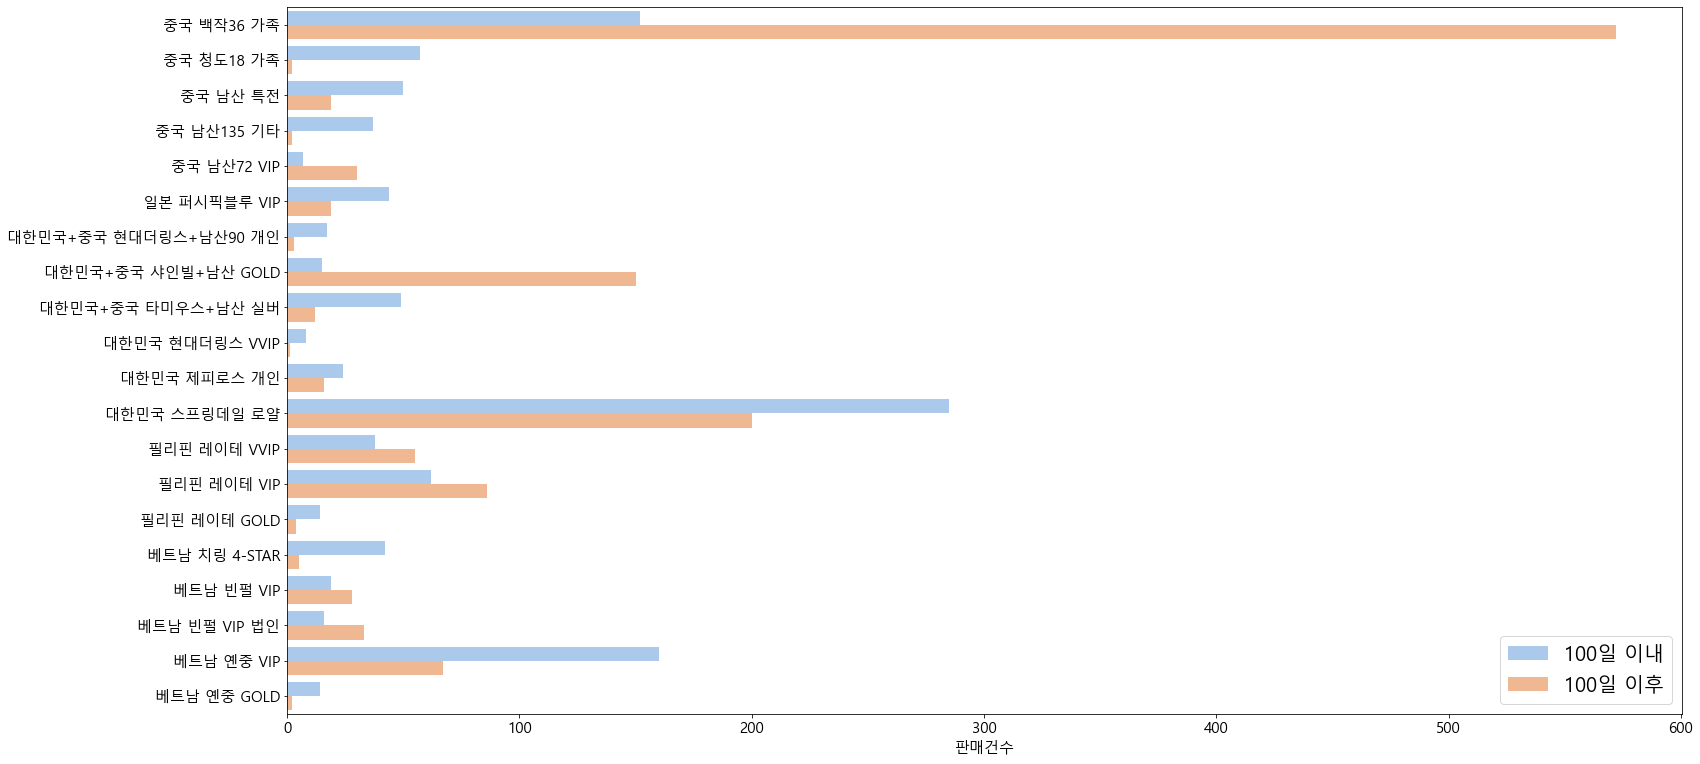

In [26]:
plt.figure(figsize=(25, 13))
ax=sns.barplot(y='회원권번호', x='count', hue='days', data=dt)
#plt.title('출시 이후 100일 이내와 100일 이후 판매건수 비교', fontsize=25)
plt.xticks(fontsize=15)
y_label = ['중국 백작36 가족', '중국 청도18 가족', '중국 남산 특전',
           '중국 남산135 기타', '중국 남산72 VIP', '일본 퍼시픽블루 VIP',
           '대한민국+중국 현대더링스+남산90 개인', '대한민국+중국 샤인빌+남산 GOLD',
           '대한민국+중국 타미우스+남산 실버', '대한민국 현대더링스 VVIP',
           '대한민국 제피로스 개인', '대한민국 스프링데일 로얄',
           '필리핀 레이테 VVIP', '필리핀 레이테 VIP', '필리핀 레이테 GOLD',
           '베트남 치링 4-STAR', '베트남 빈펄 VIP', '베트남 빈펄 VIP 법인',
           '베트남 옌중 VIP', '베트남 옌중 GOLD']
ax.set_yticklabels(y_label)  
plt.yticks(label=y_label, fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('판매건수', fontsize=15)
plt.ylabel('')
plt.legend(loc='lower right', fontsize=20)
plt.show()

### 10.국가별 회원권 개수

In [21]:
# 회원권
golf = pd.read_csv('데이터/골프장.csv')
ch = {'대한한국+중국' : '대한민국+중국', '대한민국_중국' : '대한민국+중국'}
golf = golf.replace({'국가' : ch})

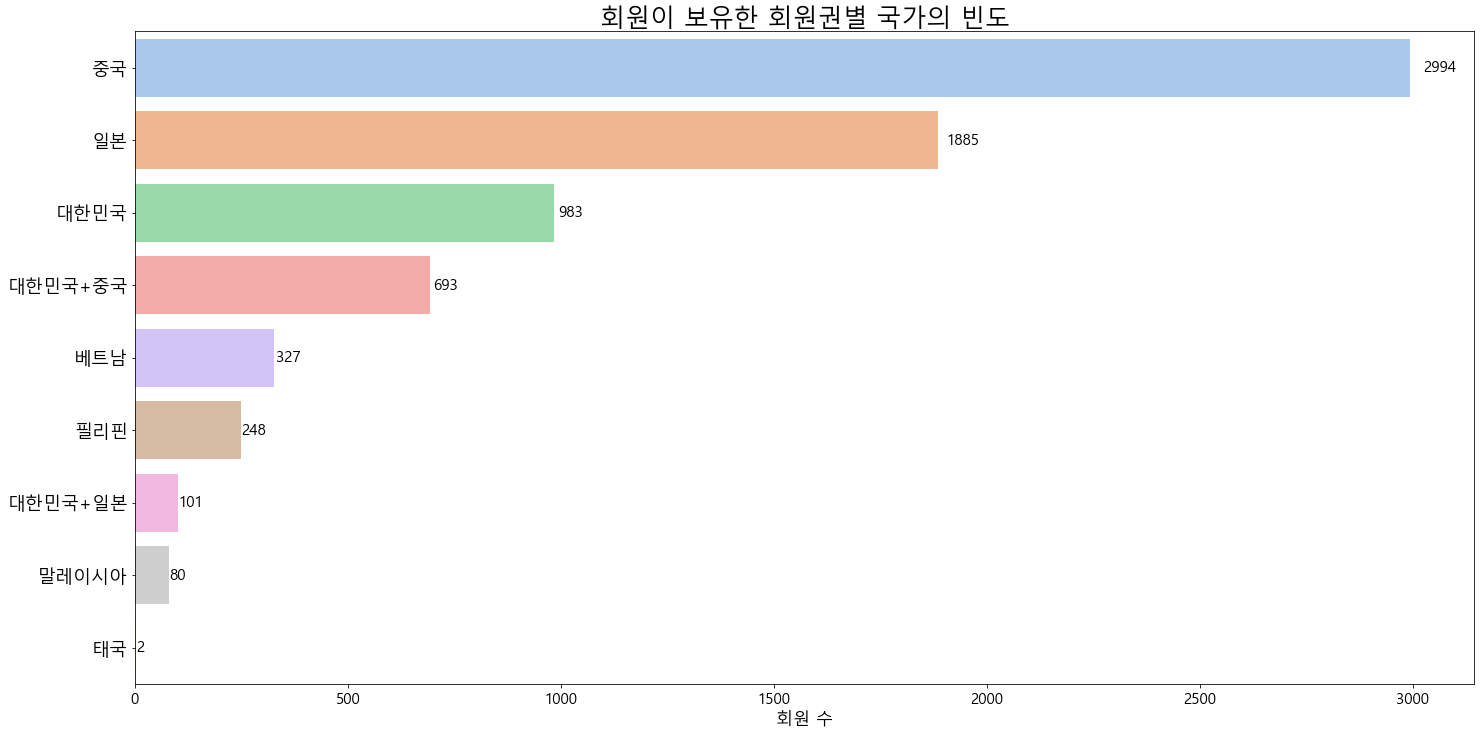

In [22]:
golf_df = pd.merge(df, golf, on='회원권번호', how='left')
df_g1 = golf_df['국가'].value_counts()
plt.figure(figsize=(24, 12))

ax = sns.barplot(y=df_g1.index,
                 x=df_g1,
                 palette='pastel')
for p in ax.patches:
    x, y, width, height = p.get_bbox().bounds
    ax.text(width*1.01, y+height/2, "%d"%(width), va='center', fontsize=15)
plt.title('회원이 보유한 회원권별 국가의 빈도', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
plt.xlabel('회원 수', fontsize=17)
plt.show()

### 11.회원권별 보유 개수

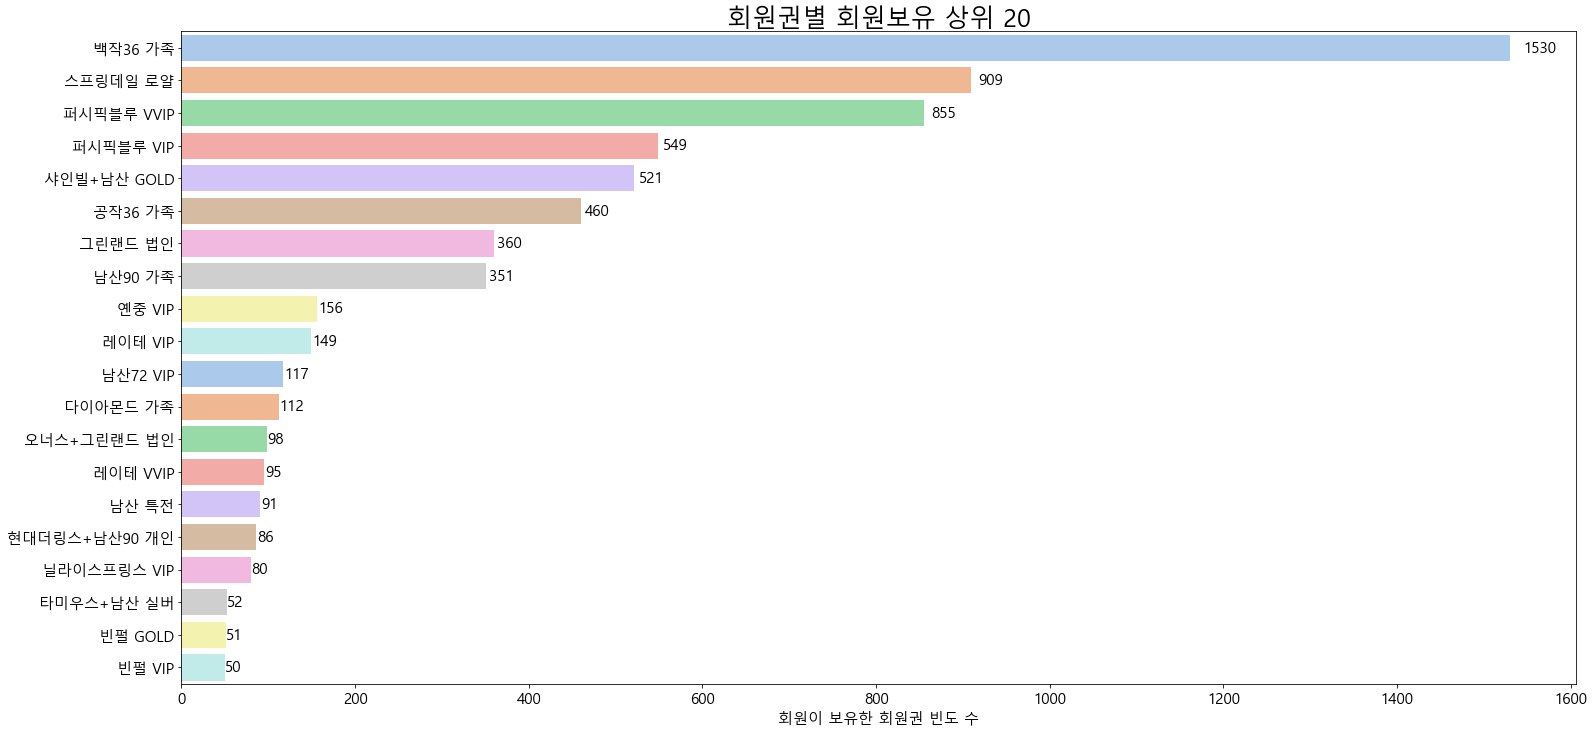

In [20]:
df_id = df['회원권번호'].value_counts().head(20)

plt.figure(figsize=(25, 12))

ax = sns.barplot(y=df_id.index,
            x=df_id,
            palette='pastel')
for p in ax.patches:
    x, y, width, height = p.get_bbox().bounds
    ax.text(width*1.01, y+height/2, "%d"%(width), va='center', fontsize=15)
y_label = ['백작36 가족', '스프링데일 로얄', '퍼시픽블루 VVIP', '퍼시픽블루 VIP',
           '샤인빌+남산 GOLD', '공작36 가족', '그린랜드 법인', '남산90 가족', 
           '옌중 VIP', '레이테 VIP', '남산72 VIP', '다이아몬드 가족', '오너스+그린랜드 법인',
           '레이테 VVIP', '남산 특전', '현대더링스+남산90 개인', '닐라이스프링스 VIP',
           '타미우스+남산 실버', '빈펄 GOLD', '빈펄 VIP']

ax.set_yticklabels(y_label)    
plt.title('회원권별 회원보유 상위 20', fontsize=25)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('회원이 보유한 회원권 빈도 수', fontsize=15)
plt.show()

### 12. 회원권 조건별 입회 건수

In [60]:
# golf : 골프장.csv / df : 입회+회원권.xlsx
benefit_df = pd.merge(golf,df,on='회원권번호',how='left')
benefit_df = benefit_df[['입회ID','회원권번호','국가_x','회원권상태','골프장이름_x','상품명_x','입회금','이용홀수','기간','회원적용','비고']]
benefit_df = benefit_df.rename(columns={'국가_x':'국가','골프장이름_x':'골프장이름','상품명_x':'상품명'})
benefit_df = benefit_df[benefit_df['회원권상태']=='보유']

benefit_df.loc[(benefit_df['회원적용']=='기1+무기명3'),'회원적용'] = '기명1+무기명3'

In [50]:
benefit_df = benefit_df[pd.notnull(benefit_df['회원적용'])]
benefit_df = benefit_df.groupby(['회원적용']).count()['입회ID']
benefit_df = pd.DataFrame(benefit_df)
benefit_df = benefit_df.sort_values('입회ID',ascending=False)
benefit_df

,입회ID
회원적용,
부부+18세이하 자녀,1910
기명1+무기명3,1618
기명2+무기명6,961
무기명4,582
기명1+무기명1,438
기명2,97
기명1+무기명4,22
기명2+준회원2,4


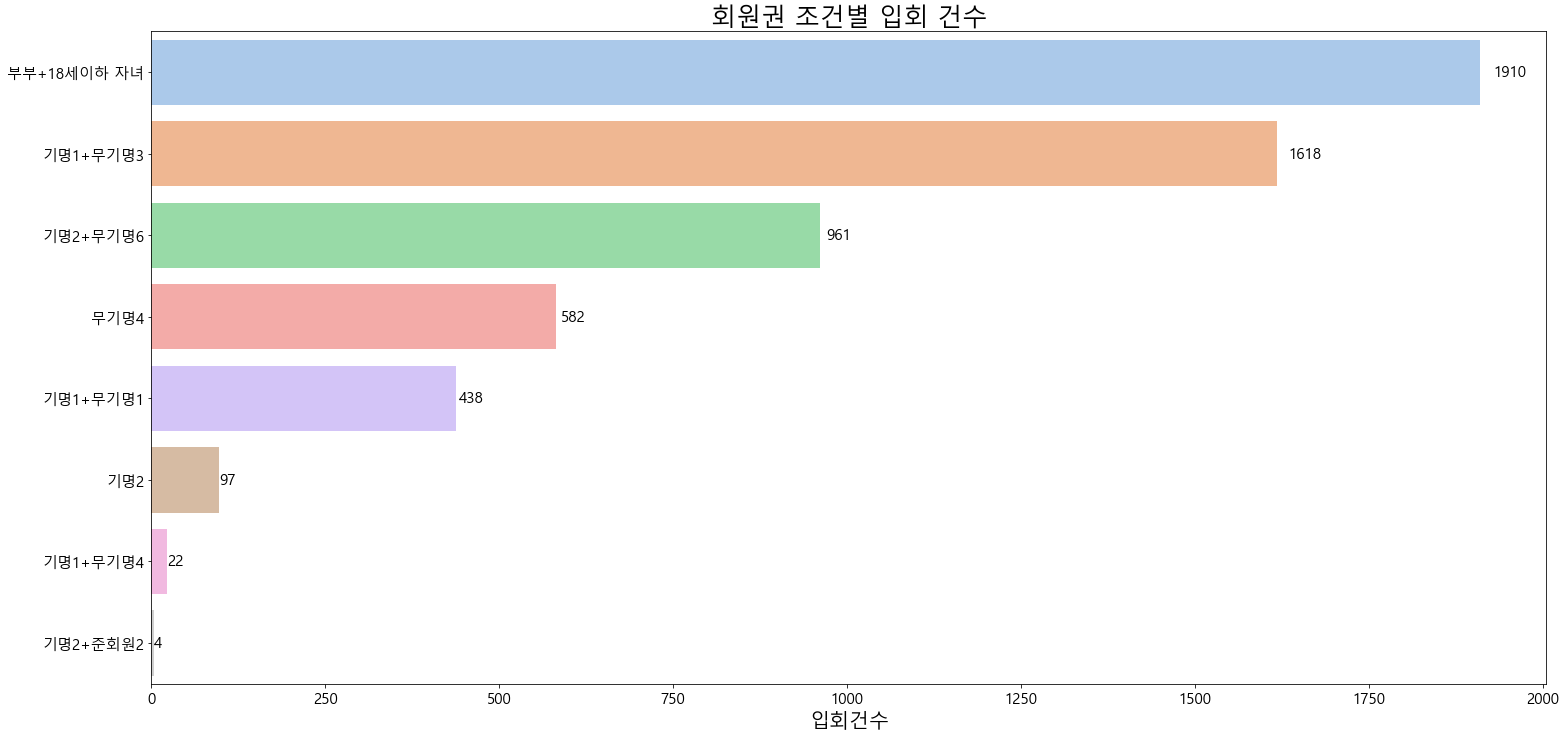

In [47]:
plt.figure(figsize=(25, 12))

ax = sns.barplot(y=benefit_df.index,
            x=benefit_df['입회ID'],
            palette='pastel')
for p in ax.patches:
    x, y, width, height = p.get_bbox().bounds
    ax.text(width*1.01, y+height/2, "%d"%(width), va='center', fontsize=15)
    
    
plt.title('회원권 조건별 입회 건수', fontsize=25)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('입회건수',fontsize=20)
plt.ylabel('')
plt.show()

### 13.회원권 보장기간별 입회 건수

In [52]:
benefit_df = benefit_df[pd.notnull(benefit_df['기간'])]
benefit_df = benefit_df[benefit_df['기간']!='마감']
period_df = benefit_df.groupby(['기간']).count()['입회ID']
period_df = pd.DataFrame(period_df)
period_df = period_df.sort_values('입회ID',ascending=False)
period_df

,입회ID
기간,
평생,2497
20년,152
10년,15


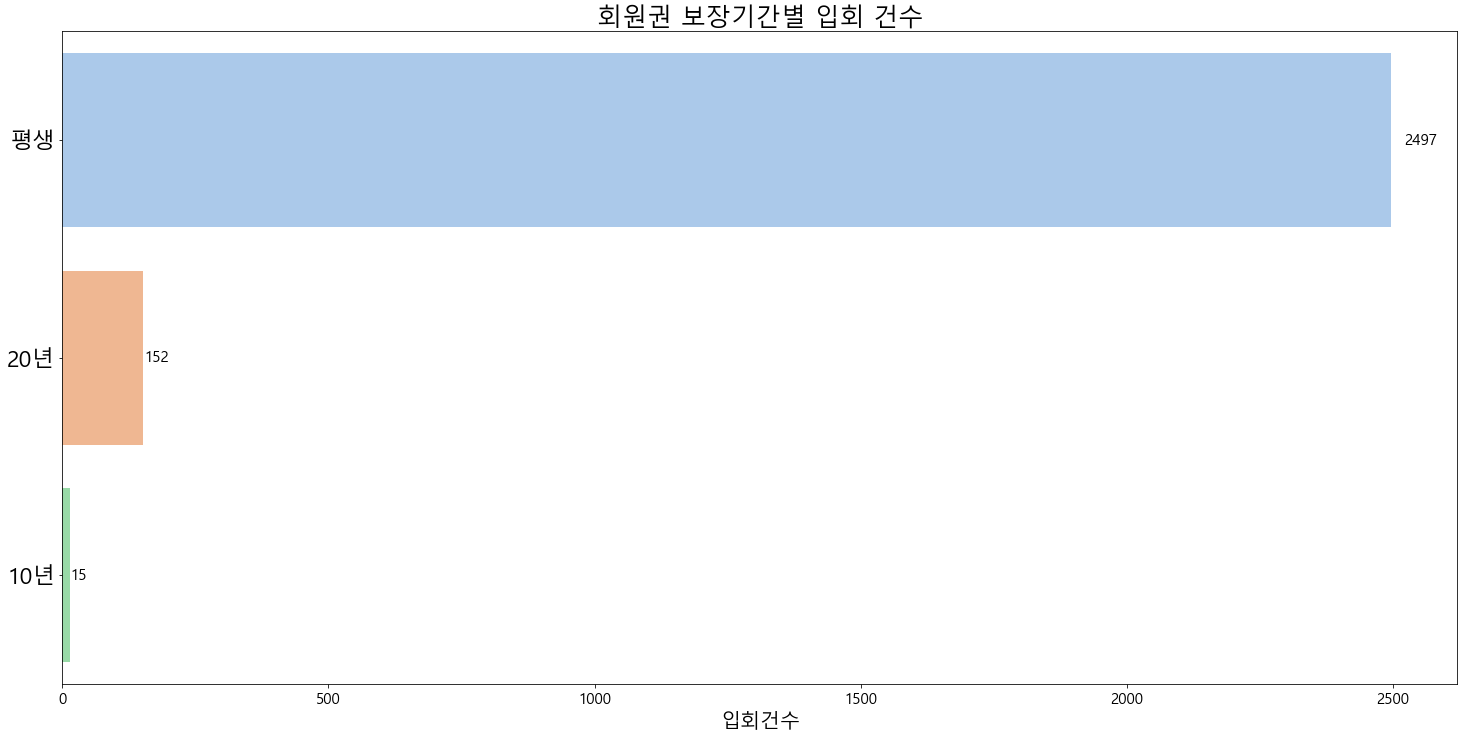

In [53]:
plt.figure(figsize=(25, 12))

ax = sns.barplot(y=period_df.index,
            x=period_df['입회ID'],
            palette='pastel')
for p in ax.patches:
    x, y, width, height = p.get_bbox().bounds
    ax.text(width*1.01, y+height/2, "%d"%(width), va='center', fontsize=15)
    
    
plt.title('회원권 보장기간별 입회 건수', fontsize=25)
plt.yticks(fontsize=23)
plt.xticks(fontsize=15)
plt.xlabel('입회건수',fontsize=20)
plt.ylabel('')
plt.show()

### 14. 회원권 금액대별 입회 건수

In [61]:
money_df = benefit_df[pd.notnull(benefit_df['입회금'])]

money_df['입회금'] = money_df['입회금']/10000
money_df['입회금'] = money_df['입회금'].round(0).astype(int)
money_df = money_df[money_df['입회금']>0]

money_df.loc[money_df['입회금']<1000,'MONEY_GRP'] = '1000만원 이하'
money_df.loc[(money_df['입회금']>=1000) & (money_df['입회금']<2000),'MONEY_GRP'] = '1000만원대'
money_df.loc[(money_df['입회금']>=2000) & (money_df['입회금']<3000),'MONEY_GRP'] = '2000만원대'
money_df.loc[(money_df['입회금']>=3000) & (money_df['입회금']<4000),'MONEY_GRP'] = '3000만원대'
money_df.loc[money_df['입회금']>=4000,'MONEY_GRP'] = '4000만원 이상'

money = money_df['MONEY_GRP'].value_counts(ascending=True)
money

4000만원 이상     146
3000만원대       305
2000만원대      1923
1000만원대      2558
1000만원 이하    3127
Name: MONEY_GRP, dtype: int64

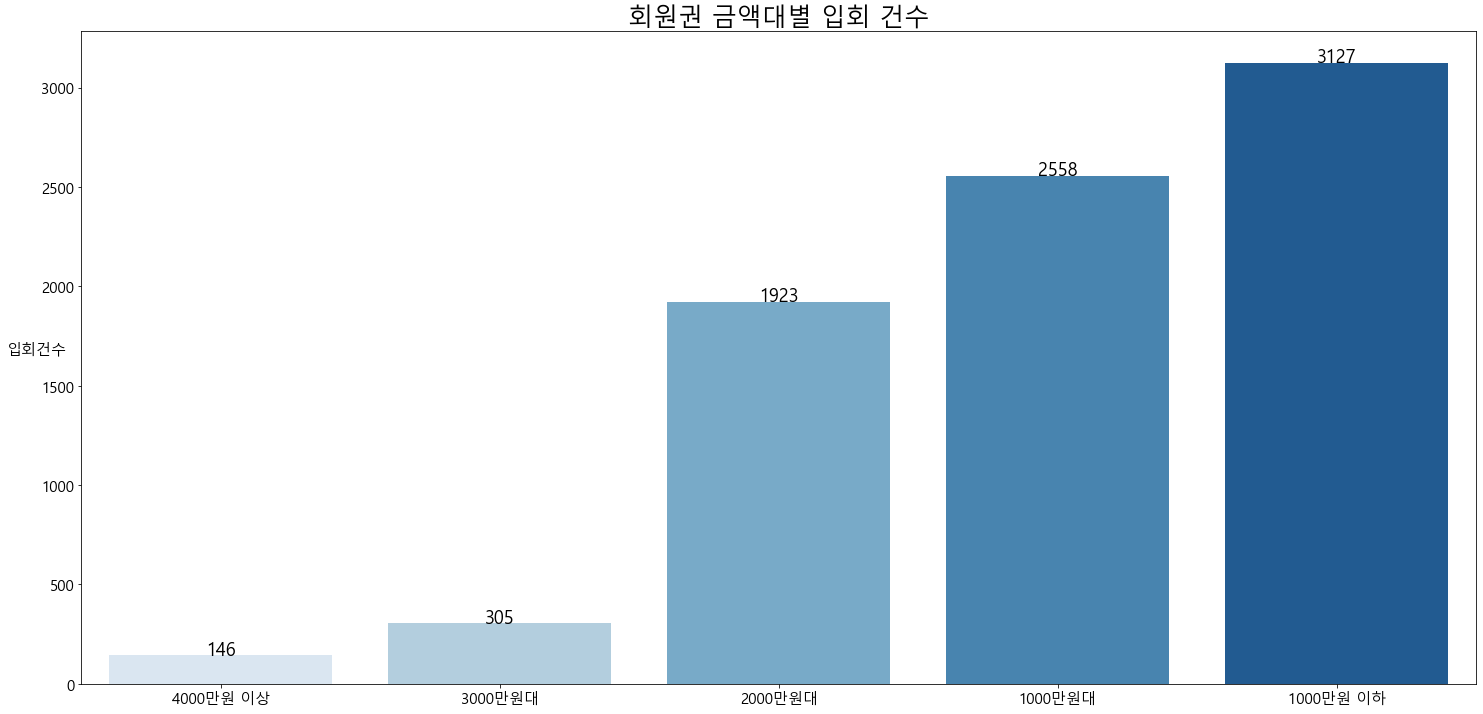

In [62]:
plt.figure(figsize=(25, 12))
ax = sns.barplot(x=money.index,
                 y=money,
                 palette='Blues')

for p in ax.patches:
    ax.annotate("%d"%(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', fontsize=18)
    
plt.title('회원권 금액대별 입회 건수', fontsize=25)
plt.yticks(fontsize=15)
plt.xticks(fontsize =15)
plt.ylabel('입회건수', fontsize=15, rotation=360)
plt.xlabel('', fontsize=15)
plt.show()

### 15. 회원권별 양도 비율

In [59]:
df = pd.read_excel('데이터/입회+회원권.xlsx')
df.rename(columns={'회원권_회원권번호' : '회원권번호'}, inplace=True)
del_col = ['고객번호', '입회_회원권번호', 'CMS코드']
df.drop(del_col, axis=1, inplace=True)

In [36]:
# 회원권별 양도 비율 (각 회원권 대비)
membership_by = df.groupby(['회원권번호', '회원권상태']).sum()['입회ID']
membership_by_sum = df.groupby(['회원권번호']).sum()['입회ID']

membership_by_ratio = (membership_by / membership_by_sum)*100
membership_by_ratio = round(membership_by_ratio.unstack().fillna(0), 2)
membership_by_ratio = pd.DataFrame(membership_by_ratio)

membership_top = membership_by_ratio.sort_values('양도',ascending=False).head(10)
membership_top

회원권상태,보상,보유,양도,종료
회원권번호,,,,
CN27-01,0.00,24.97,75.03,0.00
CMS-02,0.00,49.88,50.12,0.00
CSN13-02,0.00,25.00,49.99,25.01
CMS-03,0.00,53.33,46.67,0.00
KCON-01,0.00,66.67,22.21,11.11
CD-01,15.85,63.08,19.69,1.39
KH-02,0.00,80.64,19.36,0.00
KO-01,0.00,80.00,16.67,3.33
KJ-02,0.00,82.17,16.04,1.79


In [37]:
# 대한민국 + 중국 제외
membership_top = membership_by_ratio.sort_values('양도',ascending=False)
membership_top_ver2 = pd.merge(membership_top,golf,on='회원권번호',how='left')
membership_top_ver2 = membership_top_ver2[(membership_top_ver2['국가']!='중국')&(membership_top_ver2['국가']!='대한민국')&(membership_top_ver2['국가']!='대한민국+중국')]
membership_top_ver2 = membership_top_ver2[membership_top_ver2['양도']>0.0]
membership_top_ver2.drop(['국가','골프장이름','상품명'],axis=1,inplace=True)
membership_top_ver2 = membership_top_ver2.set_index('회원권번호')
membership_top_ver2

,보상,보유,양도,종료
회원권번호,,,,
JG-02,0.0,83.94,8.93,7.13
VY-02,0.0,85.72,5.71,8.57
KCOG-02,0.0,93.75,5.36,0.89
VC-01,0.0,96.00,4.00,0.00
JG-03,0.0,95.94,3.38,0.68
VY-01,0.0,97.01,2.31,0.67
VV-01,0.0,97.40,1.30,1.30
JP-02,0.0,94.28,0.16,5.57


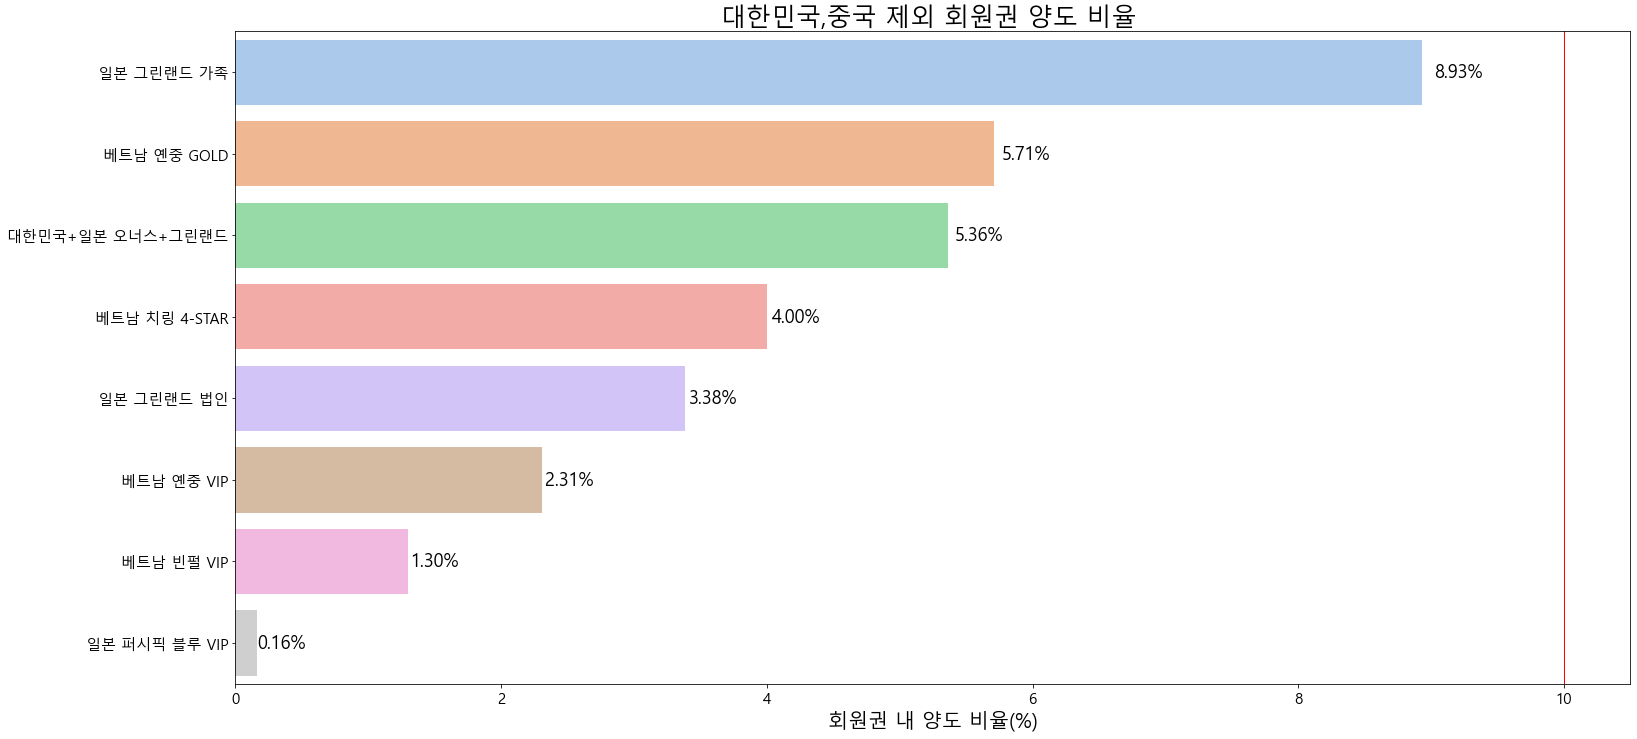

In [38]:
plt.figure(figsize=(25, 12))

ax = sns.barplot(y=membership_top_ver2.index,
            x=membership_top_ver2['양도'],
            palette='pastel')
for p in ax.patches:
    x, y, width, height = p.get_bbox().bounds
    ax.text(width*1.01, y+height/2,"%.2f%%"%(width), va='center', fontsize=18)
    
y_label = ['일본 그린랜드 가족','베트남 옌중 GOLD','대한민국+일본 오너스+그린랜드','베트남 치링 4-STAR',
           '일본 그린랜드 법인','베트남 옌중 VIP','베트남 빈펄 VIP','일본 퍼시픽 블루 VIP']

ax.set_yticklabels(y_label)    
plt.title('대한민국,중국 제외 회원권 양도 비율 ', fontsize=25)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('회원권 내 양도 비율(%)',fontsize=20)
plt.ylabel('')
plt.axvline(x=10, color='r', linewidth=1)
plt.show()

## 분석(2) 매출

총 8,965건 중 8,457건의 입회한 회원 정보 이용 <br>
2006.11~2021.07의 매출 파악

In [16]:
data = pd.read_csv('데이터/입회DB.csv')
data.head()

,입회ID,고객번호,회원권번호,CMS코드,입회일,실금액,회원권상태,계약직원,담당직원
0,1,2000116,CB-01,434.0,2007-05-18,24400000,보유,김진호,유미영
1,2,2000367,CB-01,428.0,2007-05-14,0,보유,유미영,유미영
2,3,2019506,CB-01,261.0,2008-03-03,0,보상,김진호,유미영
3,4,2019561,CB-01,951.0,2019-09-18,0,보유,유미영,유미영
4,5,2019578,CB-01,434.0,2007-05-18,0,보유,NaN,유미영


In [17]:
# 입회일 기준으로 연도와 월을 추출
data['year'] = data.입회일.str[:4]
data['month'] = data.입회일.str[5:7]

### 01.연도별 및 월별 매출

In [18]:
#히트맵작성을 위한 피벗 테이블
df = pd.pivot_table(data, index = 'month', columns = 'year', values = '실금액', aggfunc = 'sum')
df.sort_index(ascending = False,inplace = True)
df[:] = df[:] / 100000000

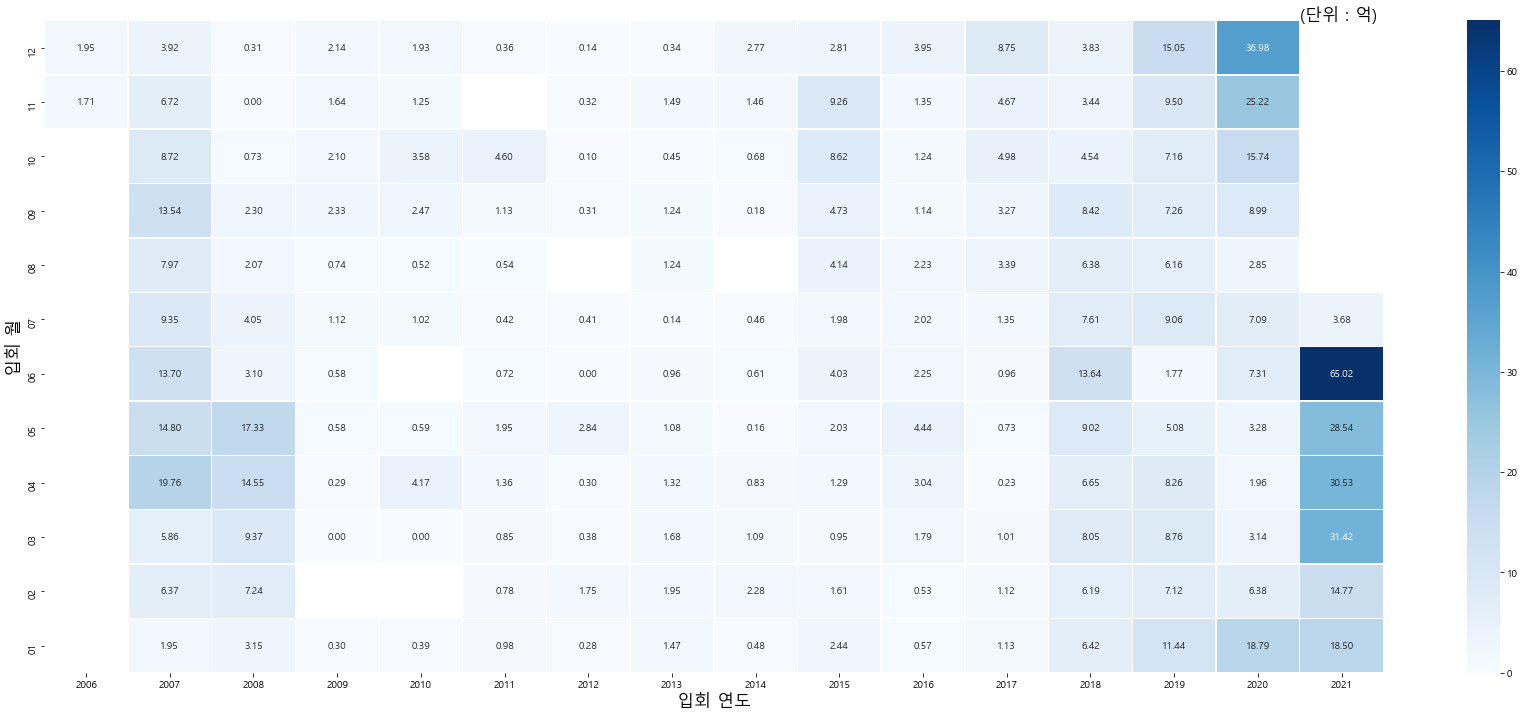

In [19]:
plt.figure(figsize=(30,12))
ax = sns.heatmap(df,cmap = 'Blues',
                 linewidths = 0.5,
                 annot = True,
                 fmt = '.2f')

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

#plt.title('연도별 및 월별 입회 매출', fontsize=20)
plt.text(15,0,'(단위 : 억)',fontsize=17)
plt.xlabel('입회 연도', fontsize=17)
plt.ylabel('입회 월', fontsize=17)
plt.show() 

### 02.연도별 및 연령대별 매출

In [20]:
df = pd.read_excel('데이터/입회회원.xlsx')

# 나이를 만드는 과정
df['입회일'] = pd.to_datetime(df['입회일'], format="%Y-%m-%d")
df['생년월일'] = pd.to_datetime(df['생년월일'], format="%Y-%m-%d")

df = df[pd.notnull(df['입회일'])]
df = df[pd.notnull(df['생년월일'])]

df['A_YEAR'] = pd.DatetimeIndex(df['입회일']).year
df['A_MONTH'] = pd.DatetimeIndex(df['입회일']).month
df['A_DAY'] = pd.DatetimeIndex(df['입회일']).day
# df['A_YEAR'] = df['A_YEAR'].astype(int)

df['B_YEAR'] = pd.DatetimeIndex(df['생년월일']).year
df['B_MONTH'] = pd.DatetimeIndex(df['생년월일']).month
df['B_DAY'] = pd.DatetimeIndex(df['생년월일']).day

df['AGE'] = 2021 - df['B_YEAR']

df['AGE_GRP'] = 0

df.loc[df['AGE'] < 20, 'AGE_GRP'] = '10대 이하'
df.loc[(df['AGE'] >= 20) & (df['AGE'] < 30), 'AGE_GRP'] = '20대'
df.loc[(df['AGE'] >= 30) & (df['AGE'] < 40), 'AGE_GRP'] = '30대'
df.loc[(df['AGE'] >= 40) & (df['AGE'] < 50), 'AGE_GRP'] = '40대'
df.loc[(df['AGE'] >= 50) & (df['AGE'] < 60), 'AGE_GRP'] = '50대'
df.loc[(df['AGE'] >= 60) & (df['AGE'] < 70), 'AGE_GRP'] = '60대'
df.loc[(df['AGE'] >= 70) & (df['AGE'] < 80), 'AGE_GRP'] = '70대'
df.loc[df['AGE'] >= 80, 'AGE_GRP'] = '80세 이상'

In [21]:
df2 = pd.pivot_table(df, index = 'AGE_GRP', columns = 'A_YEAR', values = '실금액', aggfunc = 'sum')
df2[:] = df2[:] / 100000000
df2.fillna(0,inplace = True)

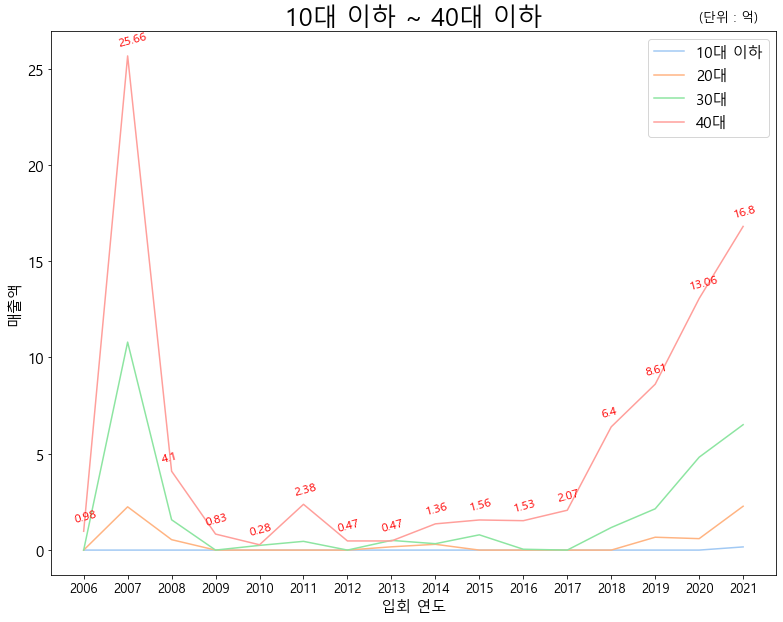

In [22]:
age1 = ['10대 이하', '20대', '30대', '40대']

plt.figure(figsize=(13, 10))
ax1=plt.plot(df2.iloc[0,:], label='10대 이하')
ax2=plt.plot(df2.iloc[1,:], label='20대')
ax3=plt.plot(df2.iloc[2,:], label='30대')
ax4=plt.plot(df2.iloc[3,:], label='40대')
plt.text(2020,27.5,'(단위 : 억)',fontsize=13)
for i,j in zip(df2.iloc[3,:].index,df2.iloc[3,:]):
    plt.text(i-0.25,j+0.5,round(j,2),c = 'red',fontsize = 12,rotation = 15)


plt.legend(loc='upper right', fontsize=15)
plt.title('10대 이하 ~ 40대 이하', fontsize=25)
plt.xticks(np.arange(2006, 2022, 1), fontsize=13)
plt.yticks(fontsize=15)
plt.ylabel('매출액', fontsize=15)
plt.xlabel('입회 연도', fontsize=15)
plt.show()

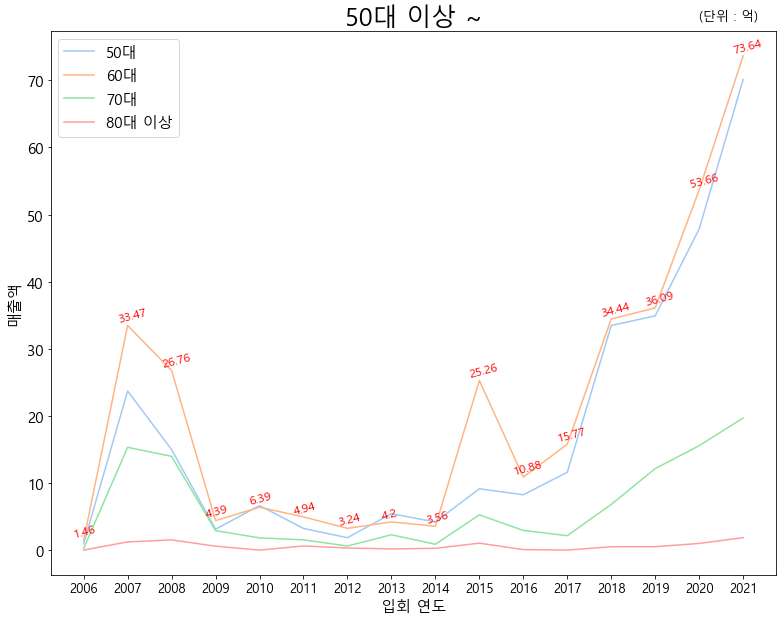

<Figure size 432x288 with 0 Axes>

In [23]:
age2 = ['50대', '60대', '70대', '80세 이상']

plt.figure(figsize=(13, 10))
plt.plot(df2.iloc[4,:], label='50대')
plt.plot(df2.iloc[5,:], label='60대')
plt.plot(df2.iloc[6,:], label='70대')
plt.plot(df2.iloc[7,:], label='80대 이상')
for i,j in zip(df2.iloc[5,:].index,df2.iloc[5,:]):
    plt.text(i-0.25,j+0.5,round(j,2),c = 'red',fontsize = 12,rotation = 15)


plt.text(2020,79,'(단위 : 억)',fontsize=13)
plt.title('50대 이상 ~', fontsize=25)
plt.xticks(np.arange(2006, 2022, 1), fontsize=13)
plt.yticks(fontsize=15)
plt.xlabel('입회 연도', fontsize=15)
plt.ylabel('매출액', fontsize=15)
plt.legend(loc='upper left', fontsize=15)
plt.show()

### 03. 고객등급별 평균 매출

In [73]:
df = pd.read_excel('데이터/입회회원.xlsx')

df['입회일'] = pd.to_datetime(df['입회일'], format="%Y-%m-%d")
df['생년월일'] = pd.to_datetime(df['생년월일'], format="%Y-%m-%d")

df = df[pd.notnull(df['입회일'])]
df = df[pd.notnull(df['생년월일'])]

df['A_YEAR'] = pd.DatetimeIndex(df['입회일']).year
df['A_MONTH'] = pd.DatetimeIndex(df['입회일']).month
df['A_DAY'] = pd.DatetimeIndex(df['입회일']).day
# df['A_YEAR'] = df['A_YEAR'].astype(int)

df['B_YEAR'] = pd.DatetimeIndex(df['생년월일']).year
df['B_MONTH'] = pd.DatetimeIndex(df['생년월일']).month
df['B_DAY'] = pd.DatetimeIndex(df['생년월일']).day

df['AGE'] = 2021 - df['B_YEAR']

df['AGE_GRP'] = 0

df.loc[df['AGE'] < 20, 'AGE_GRP'] = '10대 이하'
df.loc[(df['AGE'] >= 20) & (df['AGE'] < 30), 'AGE_GRP'] = '20대'
df.loc[(df['AGE'] >= 30) & (df['AGE'] < 40), 'AGE_GRP'] = '30대'
df.loc[(df['AGE'] >= 40) & (df['AGE'] < 50), 'AGE_GRP'] = '40대'
df.loc[(df['AGE'] >= 50) & (df['AGE'] < 60), 'AGE_GRP'] = '50대'
df.loc[(df['AGE'] >= 60) & (df['AGE'] < 70), 'AGE_GRP'] = '60대'
df.loc[(df['AGE'] >= 70) & (df['AGE'] < 80), 'AGE_GRP'] = '70대'
df.loc[df['AGE'] >= 80, 'AGE_GRP'] = '80세 이상'

In [74]:
df['고객등급']

0       ACE
1       ACE
2       ACE
3       ACE
4       ACE
       ... 
8960    ACE
8961    ACE
8962    ACE
8963    ACE
8964    ACE
Name: 고객등급, Length: 8457, dtype: object

In [75]:
df2 = df.groupby(['입회_고객번호','고객등급']).sum()['실금액']
df2 = df2.reset_index()
df2

,입회_고객번호,고객등급,실금액
0,36892,ACE,57400000
1,36923,ACE,15400000
2,36951,VIP,15400000
3,36982,VIP,15400000
4,37043,ACE,37400000
...,...,...,...
7308,20211392,ACE,9900000
7309,20211393,ACE,9900000
7310,20211394,ACE,11000000
7311,20211395,ACE,11000000


In [76]:
df3 = df2.groupby('고객등급').mean()
df3['실금액'] = df3['실금액'] / 10000
df3

,입회_고객번호,실금액
고객등급,,
ACE,1.571206e+07,1144.767387
MVG,1.395236e+07,3080.740741
SVIP,1.209280e+07,2247.456522
VIP,1.318962e+07,2182.092308


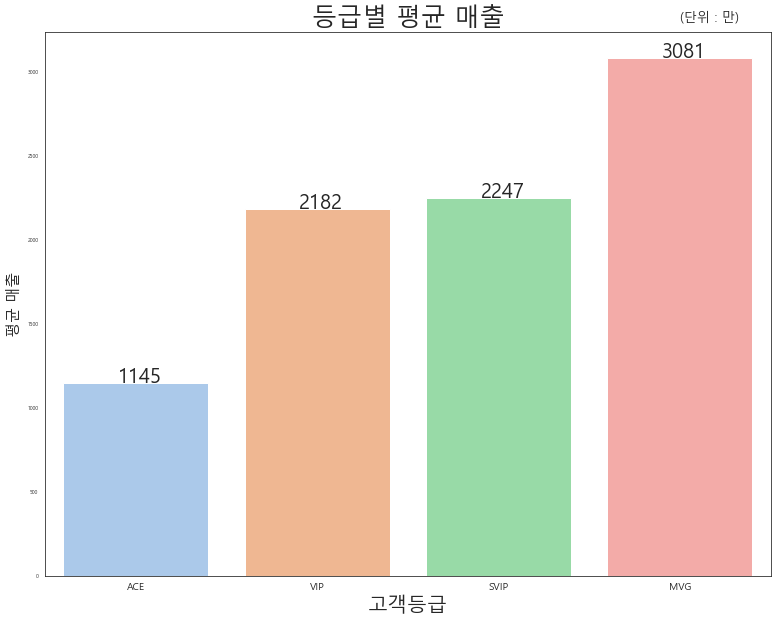

In [77]:
plt.figure(figsize=(13, 10))
sns.barplot(x = df3.index, y= df3.실금액,order=['ACE','VIP','SVIP','MVG'])
plt.ylabel('평균 매출', fontsize=15)
j = 0
for i in df3.loc[['ACE','VIP','SVIP','MVG'],'실금액']:
    plt.text(x= j-0.1, y= i-0.2,s = round(i), fontsize = 20)
    j += 1
plt.text(3,3300,'(단위 : 만)',fontsize=13)
plt.title('등급별 평균 매출', fontsize=25)
plt.show()

In [78]:
df2 = df.groupby(['입회_고객번호']).count()
df2.reset_index(inplace=True)
df2 = df2[['입회_고객번호','고객등급','실금액']]
df2

,입회_고객번호,고객등급,실금액
0,36892,2,2
1,36923,2,2
2,36951,1,1
3,36982,2,2
4,37043,2,2
...,...,...,...
7308,20211392,1,1
7309,20211393,1,1
7310,20211394,1,1
7311,20211395,1,1


In [79]:
df3 = pd.merge(df[['입회_고객번호','고객등급']],df2, on = '입회_고객번호', how = 'right')
df3 = df3[['입회_고객번호','고객등급_x','실금액']]
df3.columns = ['고객번호', '고객등급', '보유개수']
df3

,고객번호,고객등급,보유개수
0,36892,ACE,2
1,36892,ACE,2
2,36923,ACE,2
3,36923,ACE,2
4,36951,VIP,1
...,...,...,...
8452,20211392,ACE,1
8453,20211393,ACE,1
8454,20211394,ACE,1
8455,20211395,ACE,1


In [81]:
df4 = df3.groupby('고객등급').mean()
df4

,고객번호,보유개수
고객등급,,
ACE,1.563890e+07,1.289003
MVG,1.174388e+07,3.873239
SVIP,1.112005e+07,2.200000
VIP,1.352250e+07,2.771429


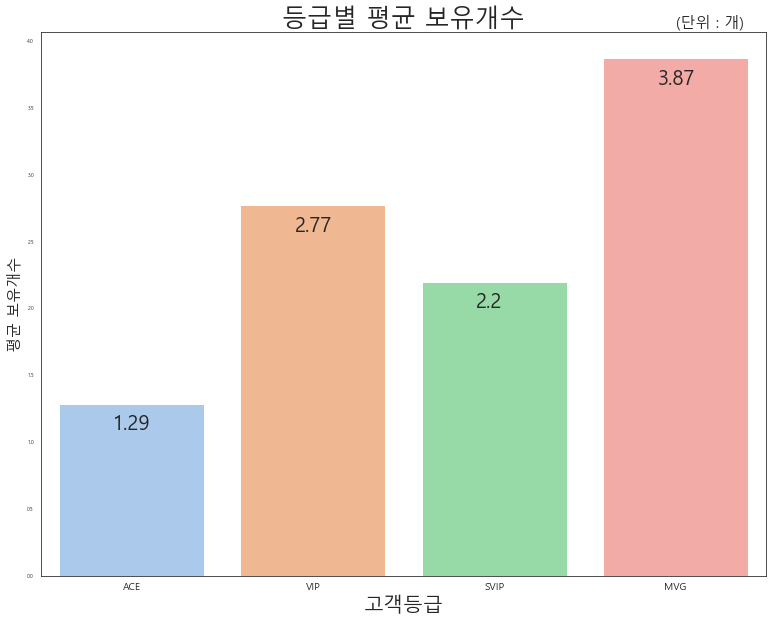

In [82]:
plt.figure(figsize=(13, 10))
sns.barplot(x = df4.index, y= df4.보유개수,order=['ACE','VIP','SVIP','MVG'])
plt.ylabel('평균 보유개수', fontsize=15)
j = 0
for i in df4.loc[['ACE','VIP','SVIP','MVG'],'보유개수']:
    plt.text(x= j-0.1, y= i-0.2,s = round(i,2), fontsize = 20)
    j += 1
plt.text(3,4.1,'(단위 : 개)',fontsize=15)
plt.title('등급별 평균 보유개수', fontsize=25)
plt.show()

### 04.역대 상위 매출 회원권

In [27]:
df2 = df.groupby('회원권번호').sum()['실금액'].sort_values(ascending = False)
df2 = pd.DataFrame(df2.reset_index())

data = pd.read_excel('데이터/회원권DB.xlsx')
df2 = pd.merge(df2, data, left_on = df2.회원권번호, right_on = '회원권번호')[['실금액','골프장이름','상품명']]

df2.loc[df2.index > 9, ['골프장이름','상품명']] = '기타'
df2

,실금액,골프장이름,상품명
0,15824600000,퍼시픽블루,VVIP
1,12864050000,백작36,가족
2,6332300000,퍼시픽블루,VIP
3,4910280000,공작36,가족
4,4574600000,옌중,VIP
...,...,...,...
58,23000000,기타,기타
59,22100000,기타,기타
60,15400000,기타,기타
61,3800000,기타,기타


In [28]:
df2['회원권'] = df2['골프장이름'] + ' ' + df2['상품명']
df2.loc[df2.회원권 == '기타 기타', '회원권'] = '기타'

In [29]:
df3 = df2.groupby('회원권').sum()
df3.sort_values(by = '실금액', ascending = False,inplace = True)

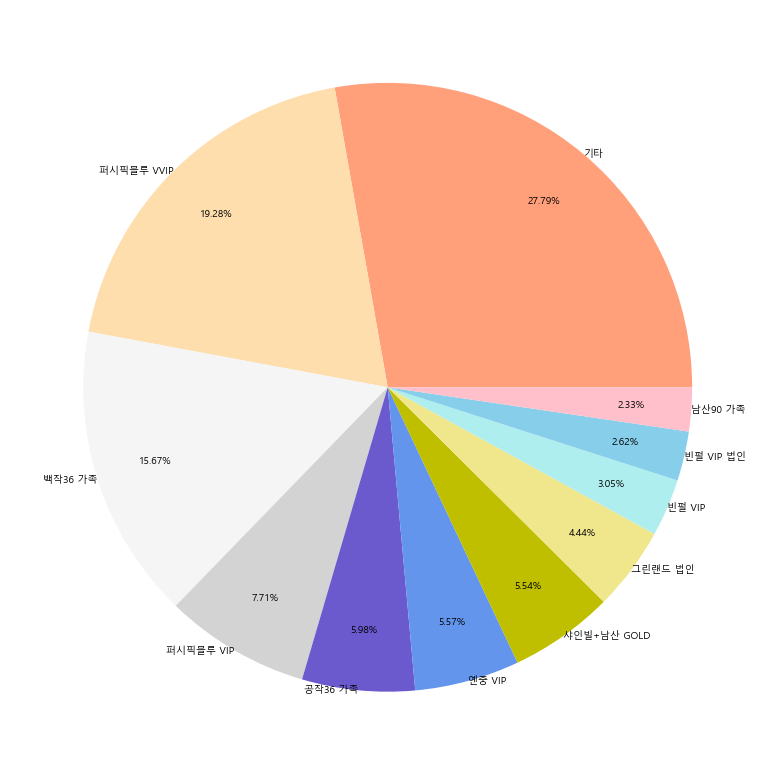

In [30]:
plt.figure(figsize=(26,14))
colors = ['lightsalmon', 'navajowhite', 'whitesmoke', 'lightgray',
          'slateblue','cornflowerblue','y','khaki',
          'paleturquoise', 'skyblue', 'pink']

plt.pie(df3.실금액,autopct = '%.2f%%',labels=df3.index,colors = colors,labeldistance=1,pctdistance = 0.8)

plt.rc('font', size=20)
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=5)  # y축 눈금 폰트 크기
plt.show()        

### 05.골프장별 1일 매출

In [31]:
df2 = df.groupby('회원권번호').sum()['실금액'].sort_values(ascending = False)
df2 = pd.DataFrame(df2.reset_index())
data = pd.read_excel('데이터/회원권DB.xlsx')

df2 = pd.merge(df2, data, left_on = df2.회원권번호, right_on = '회원권번호')[['실금액','골프장이름','상품명']]
df2

,실금액,골프장이름,상품명
0,15824600000,퍼시픽블루,VVIP
1,12864050000,백작36,가족
2,6332300000,퍼시픽블루,VIP
3,4910280000,공작36,가족
4,4574600000,옌중,VIP
...,...,...,...
58,23000000,마산재18,개인
59,22100000,신남산135,법인
60,15400000,신남산108,지정
61,3800000,신남산380,개인


In [32]:
df3 = df2[['실금액','골프장이름']].groupby('골프장이름').sum().sort_values(by='실금액', ascending = False)
df3.reset_index(inplace = True)
df3.loc[df3.index > 7, '골프장이름'] = '기타'
df4 = df3.groupby('골프장이름').sum().sort_values(by='실금액', ascending = False)
df4

,실금액
골프장이름,
퍼시픽블루,22464900000
기타,17362700000
백작36,13922010000
빈펄,6039200000
공작36,5057300000
옌중,4917200000
샤인빌+남산,4824600000
그린랜드,3978440000
레이테,3512300000


In [33]:
data = pd.read_csv('데이터/회원권출시날짜.csv')
data

,국가,골프장이름,입회일
0,대한민국,대명,2021-03-01
1,대한민국,스프링데일,2012-12-13
2,대한민국,오너스,2015-10-26
3,대한민국,용인,2018-06-19
4,대한민국,제피로스,2017-12-07
5,대한민국,현대더링스,2017-08-28
6,대한민국+일본,오너스+그린랜드,2014-02-25
7,대한민국+중국,샤인빌+남산,2017-08-23
8,대한민국+중국,오너스+남산90,2017-08-29
9,대한민국+중국,용인+남산90,2017-08-23


In [34]:
df4 = pd.merge(df4, data, left_on = df4.index, right_on = data.골프장이름, how = 'left')[['골프장이름','입회일','실금액']]
df4.drop(1, axis = 0, inplace = True)

pd.DatetimeIndex(data = df4.입회일)
pd.to_datetime('2021-07-21') - pd.DatetimeIndex(data = df4.입회일)
df4['datadiff'] = pd.to_datetime('2021-07-21') - pd.DatetimeIndex(data = df4.입회일)
df4['datadiff'] = df4['datadiff'].dt.days
df4

,골프장이름,입회일,실금액,datadiff
0,퍼시픽블루,2019-07-02,22464900000,750
2,백작36,2006-11-20,13922010000,5357
3,빈펄,2019-07-22,6039200000,730
4,공작36,2007-08-21,5057300000,5083
5,옌중,2019-01-02,4917200000,931
6,샤인빌+남산,2017-08-23,4824600000,1428
7,그린랜드,2008-04-01,3978440000,4859
8,레이테,2020-11-02,3512300000,261


In [35]:
df4['일일당 매출'] = df4.실금액 / df4.datadiff
df4

,골프장이름,입회일,실금액,datadiff,일일당 매출
0,퍼시픽블루,2019-07-02,22464900000,750,2.995320e+07
2,백작36,2006-11-20,13922010000,5357,2.598845e+06
3,빈펄,2019-07-22,6039200000,730,8.272877e+06
4,공작36,2007-08-21,5057300000,5083,9.949439e+05
5,옌중,2019-01-02,4917200000,931,5.281633e+06
6,샤인빌+남산,2017-08-23,4824600000,1428,3.378571e+06
7,그린랜드,2008-04-01,3978440000,4859,8.187775e+05
8,레이테,2020-11-02,3512300000,261,1.345709e+07


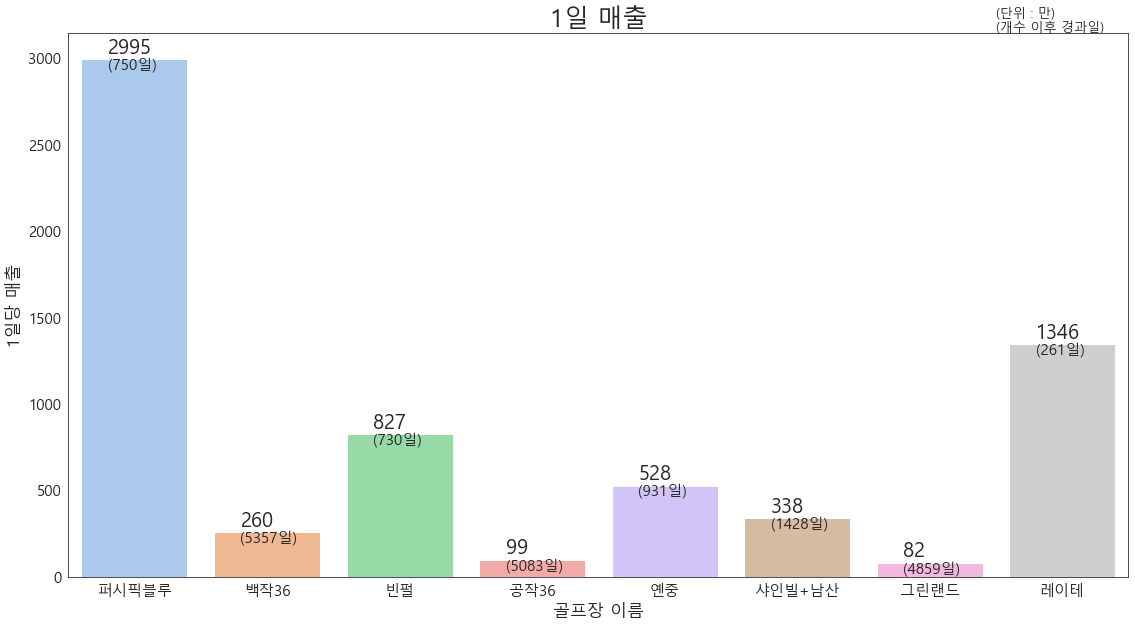

In [36]:
plt.figure(figsize=(19, 10))
sns.set_style("white")
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
sns.barplot(x = df4.골프장이름, y= df4['일일당 매출']/10000)
plt.ylabel('1일당 매출', fontsize=17)
j = 0
for i,k in zip(df4['일일당 매출']/10000,df4['datadiff']):
    plt.text(x= j-0.2, y= i+30,s = round(i), fontsize = 20)
    plt.text(x= j-0.2, y= i-60,s = '(' + str(k) + '일' + ')', fontsize = 15)
    j += 1

plt.text(6.5,3150,'(단위 : 만)\n(개수 이후 경과일)',fontsize=13)
plt.title('1일 매출', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('골프장 이름', fontsize=17)
plt.show()